# Pipeline using UnderSampling and OverSampling (SMOTE)

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime
import requests
import warnings
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
warnings.filterwarnings('ignore')

In [16]:
train_df = pd.read_csv("dev.csv")
test_df = pd.read_csv("compete.csv")

In [17]:
train_df = train_df.drop(['is_host_login', 'num_outbound_cmds'], axis=1);
test_df = test_df.drop(['is_host_login', 'num_outbound_cmds'], axis=1);

In [18]:
train_df = pd.get_dummies(train_df, columns=['protocol_type'])
test_df = pd.get_dummies(test_df, columns=['protocol_type'])

In [19]:
from sklearn import preprocessing

cat_cols = ['service', 'flag']
for col in cat_cols:
    if col in train_df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))   

In [20]:
numerical_features = list(train_df.columns[train_df.dtypes != object].values[:-1])
categorical_features = list(train_df.columns[train_df.dtypes == object].values)

corr_table = train_df.corr()
triu = corr_table.where(np.triu(np.ones(corr_table.shape) ,k=1).astype(np.bool))
to_drop = [feat for feat in triu.columns if any(triu[feat] > 0.95)]

train_df = train_df.drop(to_drop, axis=1)

for feat in to_drop:
    if feat in categorical_features:
        categorical_features.remove(feat)
    else:
        numerical_features.remove(feat)

print(f'\nFeatures dropped: {to_drop}')


Features dropped: ['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_icmp']


In [21]:
X = train_df.drop('class', axis=1)
y = train_df['class']

### UnderSampling

In [22]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
X_train_under, y_train_under = rus.fit_resample(X, y)

<AxesSubplot:>

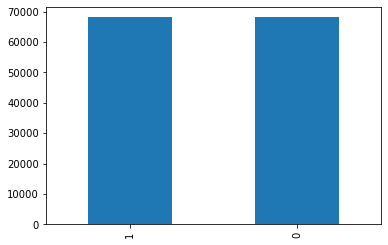

In [23]:
y_train_under.value_counts().plot.bar()

In [24]:
y_train_under.shape, X_train_under.shape, y_train_under.value_counts()

((136190,),
 (136190, 32),
 1    68095
 0    68095
 Name: class, dtype: int64)

### Train test split

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_under, y_train_under, test_size=0.3)

In [26]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

# predict the results
y_pred=clf.predict(X_test)

In [27]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, y_pred)
roc_value

0.999804194231731

In [28]:
test_df = test_df.drop(to_drop, axis=1)
test_id = test_df.Id.values
test_df = test_df.drop("Id", axis=1)

In [29]:
preds = clf.predict(test_df)
preds_lgbm = clf.predict(test_df)

* Submission CSV

In [30]:
submit = pd.DataFrame({'Id': test_id, 'class':preds})
submit.to_csv('underSampling_lgbm.csv', index=False)

--------

### OverSampling (SMOTE)

In [32]:
from imblearn.over_sampling import SMOTE 

oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X, y)

<AxesSubplot:>

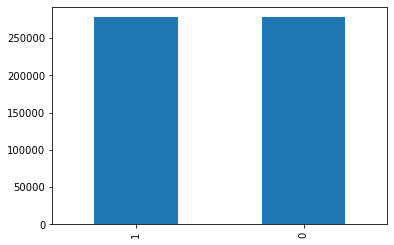

In [33]:
y_train_over.value_counts().plot.bar()

In [34]:
X_train_over.shape, y_train_over.shape, y_train_over.value_counts()

((555440, 32),
 (555440,),
 1    277720
 0    277720
 Name: class, dtype: int64)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_over, y_train_over, test_size=0.3)

In [36]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

# predict the results
y_pred=clf.predict(X_test)

In [37]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, y_pred)
roc_value

0.9998259743778191

In [38]:
preds = clf.predict(test_df)
preds_lgbm = clf.predict(test_df)

In [39]:
submit = pd.DataFrame({'Id': test_id, 'class':preds})
submit.to_csv('SMOTE_lgbm.csv', index=False)